## Testing of BLIP2-Pretrained Model

In [ ]:
%pip install bitsandbytes
%pip install accelerate

In [3]:
import cv2
import os

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration

/home/arafat/projects/flow_matching_and_llm/flow_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import sys
sys.path.append("/home/arafat/projects/flow_matching_and_llm")

# Fine Tuning

In [12]:
from transformers import Blip2VisionConfig, Blip2QFormerConfig, Blip2Config

**Download pre-processor**

In [ ]:
processor = Blip2Processor.from_pretrained('Salesforce/blip2-opt-2.7b')

**Use Model with lower number of parameters and layers (Change the configuration)**

In [27]:
vision_config = Blip2VisionConfig(
    hidden_size=768,           # Reduced from 1408
    num_hidden_layers=12,      # Reduced from 39
    num_attention_heads=12,    # Reduced from 16
    intermediate_size=3072,    # Reduced from 6144
    image_size=224,            # Keep same
    patch_size=16,             # Adjusted from 14
)

qformer_config = Blip2QFormerConfig(
    hidden_size=512,           # Reduced from 768
    num_hidden_layers=8,       # Reduced from 12
    num_attention_heads=8,     # Reduced from 12
    intermediate_size=2048,    # Reduced from 3072
    num_query_tokens=16,       # Reduced from 32
)

config = Blip2Config(
    vision_config=vision_config.to_dict(),
    qformer_config=qformer_config.to_dict(),
    use_decoder_only_language_model=True,
)

In [28]:
model = Blip2ForConditionalGeneration(config=config)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable Parameter : {trainable_params/1e9} b")
print(f"Total Parameter : {total_params / 1e9} b")
print(f"Trainable Params Size: {trainable_params * 4/(1024 * 1024 * 1024):.3f} GiB")
print(f"Total Parameters Size: {total_params * 4/ (1024 * 1024 * 1024):.3f} GiB")

Trainable Parameter : 0.241923584 b
Total Parameter : 0.241923584 b
Trainable Params Size: 0.901 GiB
Total Parameters Size: 0.901 GiB


**Or Download A pre-trrained Model and Use train the Q-Former Only**

In [22]:
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl",
                                                    load_in_4bit=True,
                                                    cache_dir="../data/cache")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 2/2 [02:09<00:00, 64.83s/it]


In [26]:

for params in model.vision_model.parameters():
    params.requires_grad = False

for params in model.language_model.parameters():
    params.requires_grad = False
    
for params in model.qformer.parameters():
    params.requires_grad = True
    
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"Trainable Parameter : {trainable_params/1e9} b")
print(f"Total Parameter : {total_params / 1e9} b")
print(f"Trainable Params Size: {trainable_params * 4/(1024 * 1024 * 1024):.3f} GiB")
print(f"Total Parameters Size: {total_params * 4/ (1024 * 1024 * 1024):.3f} GiB")

Trainable Parameter : 0.10516224 b
Total Parameter : 2.090694144 b
Trainable Params Size: 0.392 GiB
Total Parameters Size: 7.788 GiB


**Download Dataset**

In [65]:
from datasets import load_dataset, load_from_disk

In [ ]:
splits = ["train", "validation", "test"]
flickr8k = load_dataset("jxie/flickr8k", split=splits)

**Save Dataset**

In [54]:
for idx, split in enumerate(splits):
    directory = f"../data/flickr8k/{split}"
    os.makedirs(directory, exist_ok=True)
    flickr8k[idx].save_to_disk(dataset_path=directory)

Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 3362.35 examples/s]


In [66]:
train_dataset = load_from_disk("../data/flickr8k/train")

**Some samples**

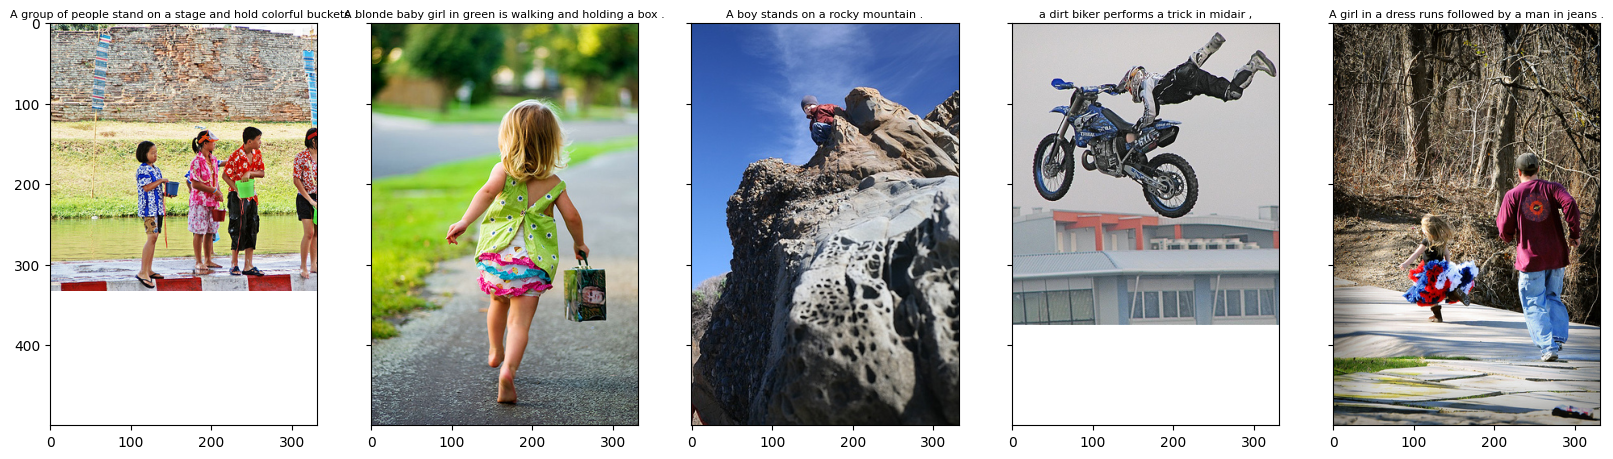

In [98]:
fig, axes = plt.subplots(1,5, figsize=(20, 20), sharex=True, sharey=True)
index = np.random.randint(0, len(train_dataset)-5)
for i in range(len(axes)):
    axes[i].imshow(train_dataset[index+i]['image'])
    caption = train_dataset[index+i]['caption_0']
    axes[i].set_title(caption, fontsize=8, fontweight="light", pad=4)

'A man is standing at the back of a room with a sticker on his shirt .'